In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
country_code = "US"
start_date='01/01/2010'
end_date='06/01/2020'
print('Country:', country_code)
print('End date:', end_date)

Country: US
End date: 06/01/2020


In [91]:
labels=['loss', 'unemployed', 'search', 'hire', 'offer', 'out_of_work']
features=['statuses_count', 'account_age', 'followers_count', 'friends_count']
print('Country:', country_code)
print('\nLabels:\n','\n'.join(labels))
print('\nFeatures:\n','\n'.join(features))

Country: CO

Labels:
 loss
unemployed
search
hire
offer
out_of_work

Features:
 statuses_count
account_age
followers_count
friends_count


In [66]:
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'

In [38]:
print('Load')
start = timer()
users_counts=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users_counts','*.parquet'))).read().to_pandas()
os.path.join(path_to_data,'official','urban',country_code,'time_series_unemployment_rate.csv')
os.path.join(path_to_data,'official','urban',country_code,'user_location_2_metro_area.csv')
print("Done in", round(timer()-start), "sec")

Load


FileNotFoundError: [Errno 2] File ../../data/official/urban/BR/user_location_2_geo_id.csv does not exist: '../../data/official/urban/BR/user_location_2_geo_id.csv'

In [182]:
df1=users_counts.merge(user_location_2_geo_id)
df1.year=df1.year.astype(int)
df1.month=df1.month.astype(int)
df1=df1.groupby(['year','month','metro_area_name'])[labels+['user_id']].sum()
for label in labels:
    df1[label]=df1[label].divide(df1['user_id'])
top_metro_areas=df1.groupby('metro_area_name')['user_id'].sum().sort_values(ascending=False).index[:5]

In [186]:
df2=labor_market_stats.merge(pop_metro_area[['geo_id','metro_area_name','pop']].drop_duplicates(['geo_id','metro_area_name']))
df2['unemployment_rate']=df2['unemployment_rate'].multiply(df2['pop'])
df2=df2.groupby(['year','month','metro_area_name']).sum()
df2=df2['unemployment_rate'].divide(df2['pop']).rename('unemployment_rate')
df2/=100

In [187]:
df=pd.concat([df1,df2],1).dropna().reset_index()
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0) 
df.drop(['year','month'],1,inplace=True)
df=df[(df.date>=pd.to_datetime(start_date))&(df.date<=pd.to_datetime(end_date))].copy()
df=df.sort_values(by=['date','metro_area_name']).set_index(['date','metro_area_name'])

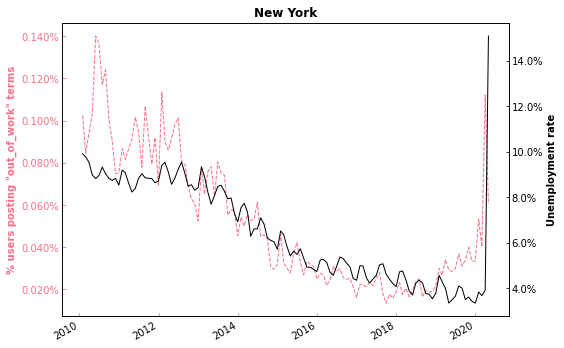

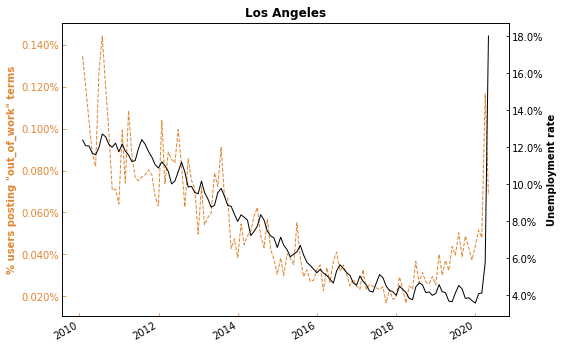

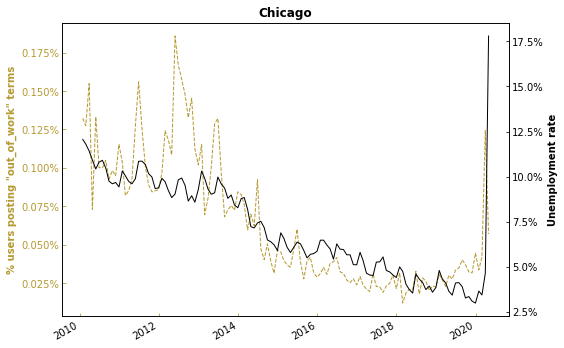

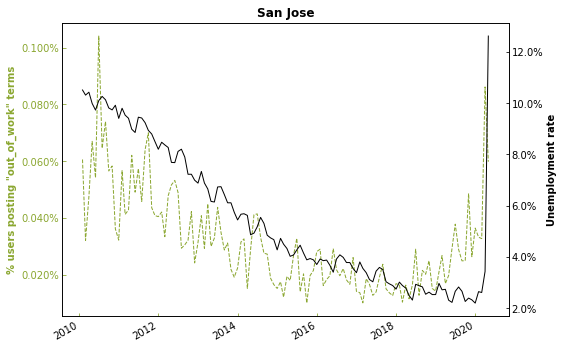

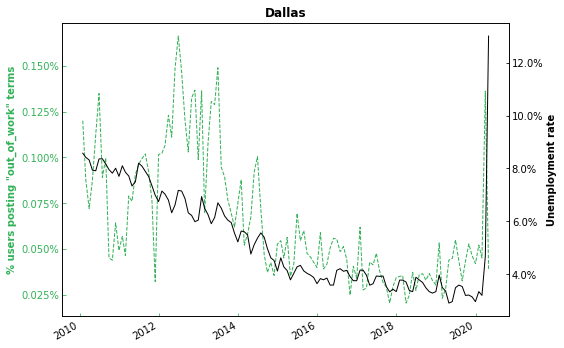

In [188]:
colors = sns.color_palette("husl", 22)
for i,metro_area in enumerate(top_metro_areas):
    fig,ax1=plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    ax1.plot(df.xs(metro_area,level='metro_area_name').index,df.xs(metro_area,level='metro_area_name')['out_of_work'],linewidth=1,color=colors[2*i],linestyle='dashed')
    ax2.plot(df.xs(metro_area,level='metro_area_name').index,df.xs(metro_area,level='metro_area_name')['unemployment_rate'],linewidth=1,color='k')
    ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
    ax2.tick_params(which='both',direction='in',pad=3,color='k')
    ax1.locator_params(axis='y',nbins=8)
    ax2.locator_params(axis='y',nbins=8)
    ax1.set_xlabel('')
    ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
    ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
    ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
    ax1.set_title(metro_area,fontweight='bold')
    fig.autofmt_xdate()
    plt.savefig(os.path.join(path_to_data,'../fig/','aggregates',metro_area+label+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')